# Map Matching Benchmarks

This notebook is intended as a supplement to the Sendai Map notebook. This notebook implements the competing map matching algorithms and tests them against the BDD100K dataset for comparison.

Note that the BDD100K dataset is extremely large and so naturally some cells will take a long time to compile; therefore, it is not a good idea to restart the kernel regularly when testing within the document.

In [1]:
import networkx as nx
import osmnx as ox 
import time
from shapely.geometry import Polygon
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from algorithms import mm_utils

%matplotlib inline
#ox.__version__

/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Data Input

df = gpd.read_file("data.json", enabled_drivers="GeoJSON")

In our case, our data is already fused. But often you will have several datasets with asynchronous data that you will have to fuse first. We implemented a barebones method in mm_utils to handle this; you can see an example of how to use it in '02a Data Pre-Processing'.

Typically GPS/IMU data is recorded as Point geometries in a GDF.
However, some algorithms require a trajectory (LineStrings) despite this.
As a result, our framework requires both points (nodes) and trajectories (edges).
So we will need to create a "trajectory" by sequentially connecting our nodes

In [3]:
# I wrote a utility function to do that, provided in mm_utils.
df_nodes = df[df.geom_type == 'Point']
df_edges = mm_utils.point_to_traj(df_nodes, columns = {'timestamp':'first',
                                                       'altitude':'average',
                                                       'speed':'average',
                                                       'vertical accuracy':'last',
                                                       'horizontal accuracy':'last',
                                                       'oops':'notavalidmethod'})

oops is not a valid column in input nodes. Ignoring this column.


There may be other data assigned to the nodes which we would like the edges to also reflect.
Some algorithms may use the auxiliary data from edges, which is why this is a concern.
There's no perfect way to do this assignment, but I included a few basic methods in mm_utils: 'first' node assignment, 'average' between nodes, and 'last' node assignment. That is the columns argument I used above.

In our case the data is already in the correct CRS format.
However, if your data isn't, then this next cell is essential. (Never hurts to run it)

In [4]:
df_nodes.set_crs(4326)
df_edges.set_crs(4326)

,timestamp,altitude,speed,vertical accuracy,horizontal accuracy,geometry
0,1503703061000,25.269455,3.935,6.0,10.0,"LINESTRING (-73.99574 40.66268, -73.99571 40.6..."
1,1503703062000,25.274536,5.645,4.0,10.0,"LINESTRING (-73.99571 40.66271, -73.99565 40.6..."
2,1503703063000,25.256989,7.64,4.0,10.0,"LINESTRING (-73.99565 40.66276, -73.99558 40.6..."
3,1503703064000,25.079666,10.04,4.0,10.0,"LINESTRING (-73.99558 40.66283, -73.99550 40.6..."
4,1503703065000,24.865967,11.155,4.0,10.0,"LINESTRING (-73.99550 40.66290, -73.99542 40.6..."
5,1503703066000,24.870728,11.02,4.0,10.0,"LINESTRING (-73.99542 40.66298, -73.99534 40.6..."
6,1503703067000,24.7995,10.9,4.0,10.0,"LINESTRING (-73.99534 40.66306, -73.99526 40.6..."
7,1503703068000,24.625076,11.41,4.0,10.0,"LINESTRING (-73.99526 40.66313, -73.99516 40.6..."
8,1503703069000,24.641434,12.195,4.0,10.0,"LINESTRING (-73.99516 40.66321, -73.99507 40.6..."
9,1503703070000,24.686874,12.55,4.0,10.0,"LINESTRING (-73.99507 40.66329, -73.99496 40.6..."


In [5]:
## Network data
miny, minx, maxy, maxx = df.geometry.total_bounds

network = ox.graph_from_bbox(maxx+0.002, minx-0.002, maxy+0.002, miny-0.002, network_type="drive")
networknodes, networkedges = ox.graph_to_gdfs(network)

In [6]:
#fig, ax = ox.plot_graph(network, close=False, show=False)
#df.plot(ax=ax, markersize=3)
#plt.show()

In [7]:
from algorithms import fmm_bin
from fmm import FastMapMatchConfig

### Define map matching configurations

k = 8
radius = 0.003
gps_error = 0.0005

fmm_config = FastMapMatchConfig(k,radius,gps_error)
cfg_file = None


### Algorithm Implementation here, if not in separate .py file


###

sim1 = fmm_bin.FMM(cfg = fmm_config)
#sim2 = EKF.Sim(cfg = cfg_file)


/home/gjgress/G-RIPS-2022-Mitsubishi-A/Code/algorithms/fmm_bin.py:48: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, encoding=encoding)


Nodes 37 edges 62
[2022-07-08 16:57:22.368] [info] [network.cpp:72] Read network from file temp/network_edges.shp
[2022-07-08 16:57:22.372] [info] [network.cpp:170] Number of edges 62 nodes 37
[2022-07-08 16:57:22.372] [info] [network.cpp:171] Field index: id 11 source 0 target 1
[2022-07-08 16:57:22.372] [info] [network.cpp:174] Read network done.
[2022-07-08 16:57:22.372] [info] [network_graph.cpp:17] Construct graph from network edges start
[2022-07-08 16:57:22.372] [info] [network_graph.cpp:30] Graph nodes 37 edges 62
[2022-07-08 16:57:22.372] [info] [network_graph.cpp:31] Construct graph from network edges end
[2022-07-08 16:57:22.372] [info] [ubodt_gen_algorithm.cpp:76] Start to generate UBODT with delta 0.02
[2022-07-08 16:57:22.372] [info] [ubodt_gen_algorithm.cpp:77] Output format csv
[2022-07-08 16:57:22.378] [info] [ubodt_gen_algorithm.cpp:105] Progress 10 / 37
[2022-07-08 16:57:22.381] [info] [ubodt_gen_algorithm.cpp:105] Progress 20 / 37
[2022-07-08 16:57:22.382] [info] [u

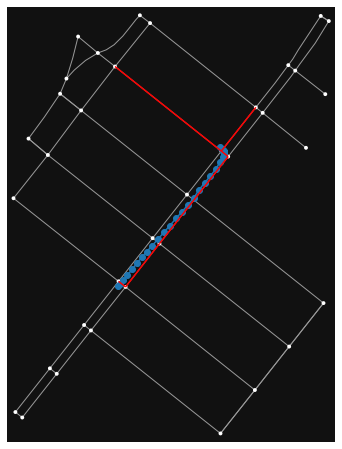

In [8]:
## If you have the ground truth, load it here

#ground_truth = 

##

sim1.run(input_nodes = df_nodes, input_edges = df_edges, network_nodes = networknodes, network_edges = networkedges) # FMM doesn't consider input nodes or network nodes, so the inclusion here is superfluous
sim1.results
sim1.plot()
#sim1.evaluate(ground_truth, match = "index") # A more standard match method would be 'geometry', but in this case index is more reliable

#sim2.run(input_nodes = df_nodes, input_edges = df_edges, network_nodes = networknodes, network_edges = networkedges) # FMM doesn't consider input nodes or network nodes, so the inclusion here is superfluous
#pred_nodes, pred_edges = sim2.results
# I did implement plot() and evaluate() for sim2
# But for demonstration, I will use mm_utils, as some programmers may choose to not implement it themselves
#sim2.plot()
#sim2.evaluate()
#mm_utils.plot(network, df_nodes.append(df_edges), sim2.results())
#mm_utils.evaluate(sim2.results(), ground_truth, match='index')